In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00


In [4]:
import torch
from datasets import load_dataset

In [5]:
# this collection of 1000 butterfly pictures
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


In [6]:
from torchvision import transforms

In [18]:
image_size = 64

# data augmentation

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]) # -1 to 1

    ]
)

def transform(examples):
  images = [preprocess(image.convert("RGB")) for image in examples['image']]
  return {"images": images}


In [19]:
dataset.set_transform(transform)

In [20]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)


In [29]:
batch = next(iter(train_dataloader))
print(batch['images'].shape, batch['images'].min().item(), batch['images'].max().item())

torch.Size([32, 3, 64, 64]) -1.0 1.0


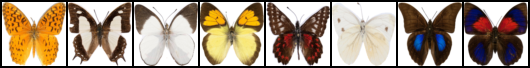

In [32]:

from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from IPython.display import display

def show_images(images, nrow=8):
    # Remap the images to (0, 1)
    images = images * 0.5 + 0.5

    # Make a grid from the tensors
    grid = make_grid(images, nrow=nrow)  # nrow images per row

    # Convert the grid tensor to a PIL Image
    to_pil = ToPILImage()
    pil_img = to_pil(grid)

    # Display the image
    display(pil_img)


show_images(batch['images'][:8])  # Display the first 8 images in the batch


In [55]:
class SampleScheduler:
  def __init__(self, time_steps=1000):
    self.time_steps = time_steps

  def corrupt(self, x, noise, amount):
    amount = amount.view(-1, 1, 1, 1) #B, 1, 1, 1
    return x * (1 - amount) + noise * amount

  def add_noise(self, x, noise):
    n = x.shape[0] # batch_size
    amount = torch.linspace(0, self.time_steps, n)
    amount = amount / self.time_steps
    return self.corrupt(x, noise, amount)


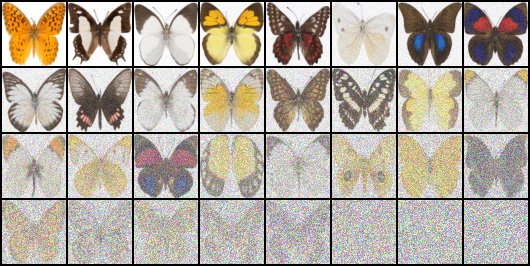

In [58]:
schedular = SampleScheduler(time_steps=1000)
noise = torch.rand_like(batch["images"])
noised_images = schedular.add_noise(batch["images"], noise)
show_images(noised_images)

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicUnet(nn.Module):
  def __init__(self, in_channels=1, out_channels=1):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.down_layers = nn.ModuleList([
        nn.Conv2d(self.in_channels, 32, kernel_size=5, padding=2),
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.Conv2d(64, 64, kernel_size=5, padding=2),
    ])

    self.up_layers = nn.ModuleList([
        nn.Conv2d(64, 64, kernel_size=5, padding=2),
        nn.Conv2d(64, 32, kernel_size=5, padding=2),
        nn.Conv2d(32, self.out_channels, kernel_size=5, padding=2),
    ])
    self.activation = nn.SiLU()
    self.downscale = nn.MaxPool2d(2)
    self.upscale = nn.Upsample(scale_factor=2)


  def forward(self, x):
    residual = []
    for i, layer in enumerate(self.down_layers):
      x = self.activation(layer(x))
      if i < 2:
        residual.append(x)
        x = self.downscale(x)


    for i, layer in enumerate(self.up_layers):
      if i > 0:
        x = self.upscale(x)
        x += residual.pop()
      x = self.activation(layer(x))

    return x



In [63]:
# training loop
nepochs = 50
lr = 1e-4
model = BasicUnet(3, 3)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []


#Train the model
for epoch in range(nepochs):
  for step, batch in enumerate(train_dataloader):
    original_images = batch['images']
    # Sample noise to add to the images
    noise = torch.rand_like(original_images)
    noisy_images = schedular.add_noise(original_images, noise)
    predictions = model(noisy_images)
    loss = F.mse_loss(predictions, noise)
    losses.append(loss.item())
    loss.backward(loss)
    optimizer.step()
    optimizer.zero_grad()



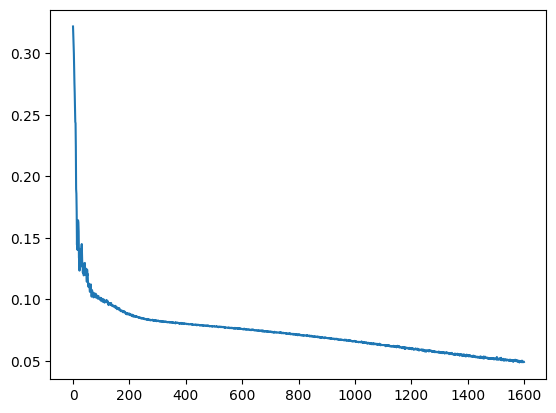

In [65]:
import matplotlib.pyplot as plt

# Plot the loss curve:
plt.plot(losses);

In [66]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.8/895.8 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.18.1-py3-none-any.whl size=1247776 sha256=8e1978af29768262cde7b22d71821bb2f70da66ce57db2b603493ecd7aaf5940
  Stored in directory: /root/.cache/pip/wheels/24/a6/0f/76cc29c67a153b1a711662ce4181c8463815f1186336ba07ec
Successfully built diffusers


In [68]:
time_steps = torch.linspace(0, 1000, 4)

In [169]:
# Random starting point (4 random images):
sample = torch.randn(4, 3, 64, 64)

In [109]:
class SampleScheduler2:
    def __init__(self, time_steps=1000):
        self.time_steps = time_steps

    def corrupt(self, x, noise, amount):
        amount = amount.view(-1, 1, 1, 1) #B, 1, 1, 1
        return x * (1 - amount) + noise * amount

    def denoise(self, x, noise, amount):
        amount = amount.view(-1, 1, 1, 1) #B, 1, 1, 1
        return x * (1 + amount) - noise * amount

    def add_noise(self, x, noise):
        n = x.shape[0] # batch_size
        amount = torch.linspace(0, self.time_steps, n)
        amount = amount / self.time_steps
        return self.corrupt(x, noise, amount)

    def remove_noise(self, x, noise):
        n = x.shape[0] # batch_size
        amount = torch.linspace(0, self.time_steps, n)
        amount = amount / self.time_steps
        return self.denoise(x, noise, amount)

    def step(self, noise_pred, t, sample):
        amount = t / self.time_steps
        return self.denoise(sample, noise_pred, amount)


In [110]:
schedular2 = SampleScheduler2()

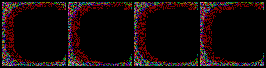

In [233]:

for i, t in enumerate(torch.linspace(0, 1000, 4)):

    # Get model pred
    with torch.no_grad():
        noise_pred = model(sample)

    # Update sample with step
    sample = schedular2.step(noise_pred, t*0.1, sample)

show_images(sample)